# Libraries

In [320]:

### System Related
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

### Data Analysis related
import math
from scipy import fftpack,signal
from mne.time_frequency import morlet # For creating Morlet Wavelet

import pandas as pd
import numpy as np

### Statistical Analysis related

from scipy.stats import levene, shapiro, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

### Interactivity
import qgrid ## Excel style DF grid view


# Visualization Related
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Upload

In [2]:
test1 = pd.read_csv('sample1.csv', header = None, names = ['Amplitude'])
test2 = pd.read_csv('sample2.csv', header = None, names = ['Amplitude'])


# Functions

In [321]:
## Some predefined Functions, in case required.

def display(df):
    """Function to display interactive Dataframe"""
    qgrid_widget =qgrid.show_grid(df,\
                                       show_toolbar=True,precision=1, \
                                       grid_options={'forceFitColumns': False,\
                                                     'defaultColumnWidth': 150,\
                                                    'maxVisibleRows': 5})
    return qgrid_widget

def adf_test(series, title=''):
    """Returns a Dickey-Fuller Test report for an entered series"""
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    
    labels = ['ADF Test Statistic', 'p-value', '# lags used', '# Observations']
    out = pd.Series(data=result[0:4], index= labels)
    
    print(out.to_string())
    
    if result[1]<0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")  


## MAPE

def mape(y_true, y_pred): 
    """
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.79
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)

   
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



# Exploratory Data Analysis

## Assumptions

-  **'1 sec'** is divided into 250 points
-  250 Data points make a Second.
-  Taking only 1st 59750 values for analysis i.e., 3 Minutes 59 seconds data
- Frequency for Spindle is in $sigma$ frequency range i.e., 11-16 Hz

## Descriptive Analysis of test1.csv data file

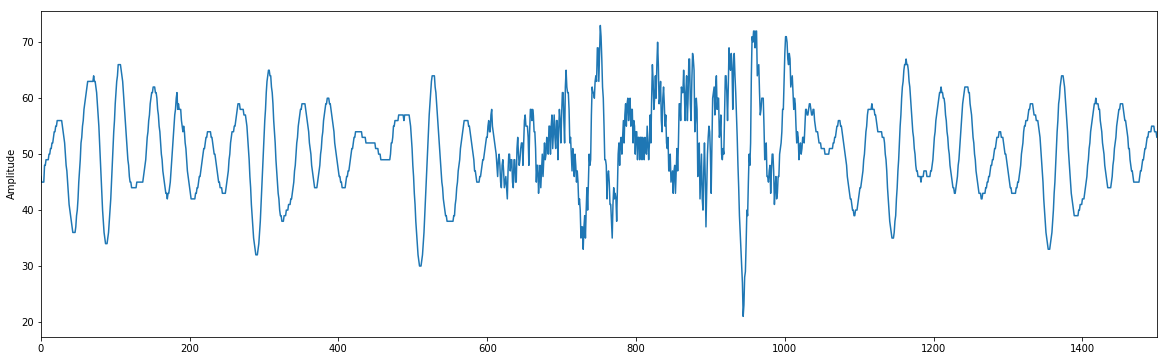

In [4]:
## Window of 6 Seconds
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xlim(0,1500) ## 250 Time stamps == 1 Sec
sns.lineplot(x=test1.index, y=test1.Amplitude, data=test1)

**Observations:**

- It seems that body vibrations are showing signs of snoring at ~3 second and ~4 second.
- During Snoring, the Crests and Troughs deviate from a sinosiodal pattern.
- Based on the above two points, A hypothesis can be generated that during Snoring the difference in Vibrational Amplitude will be high!

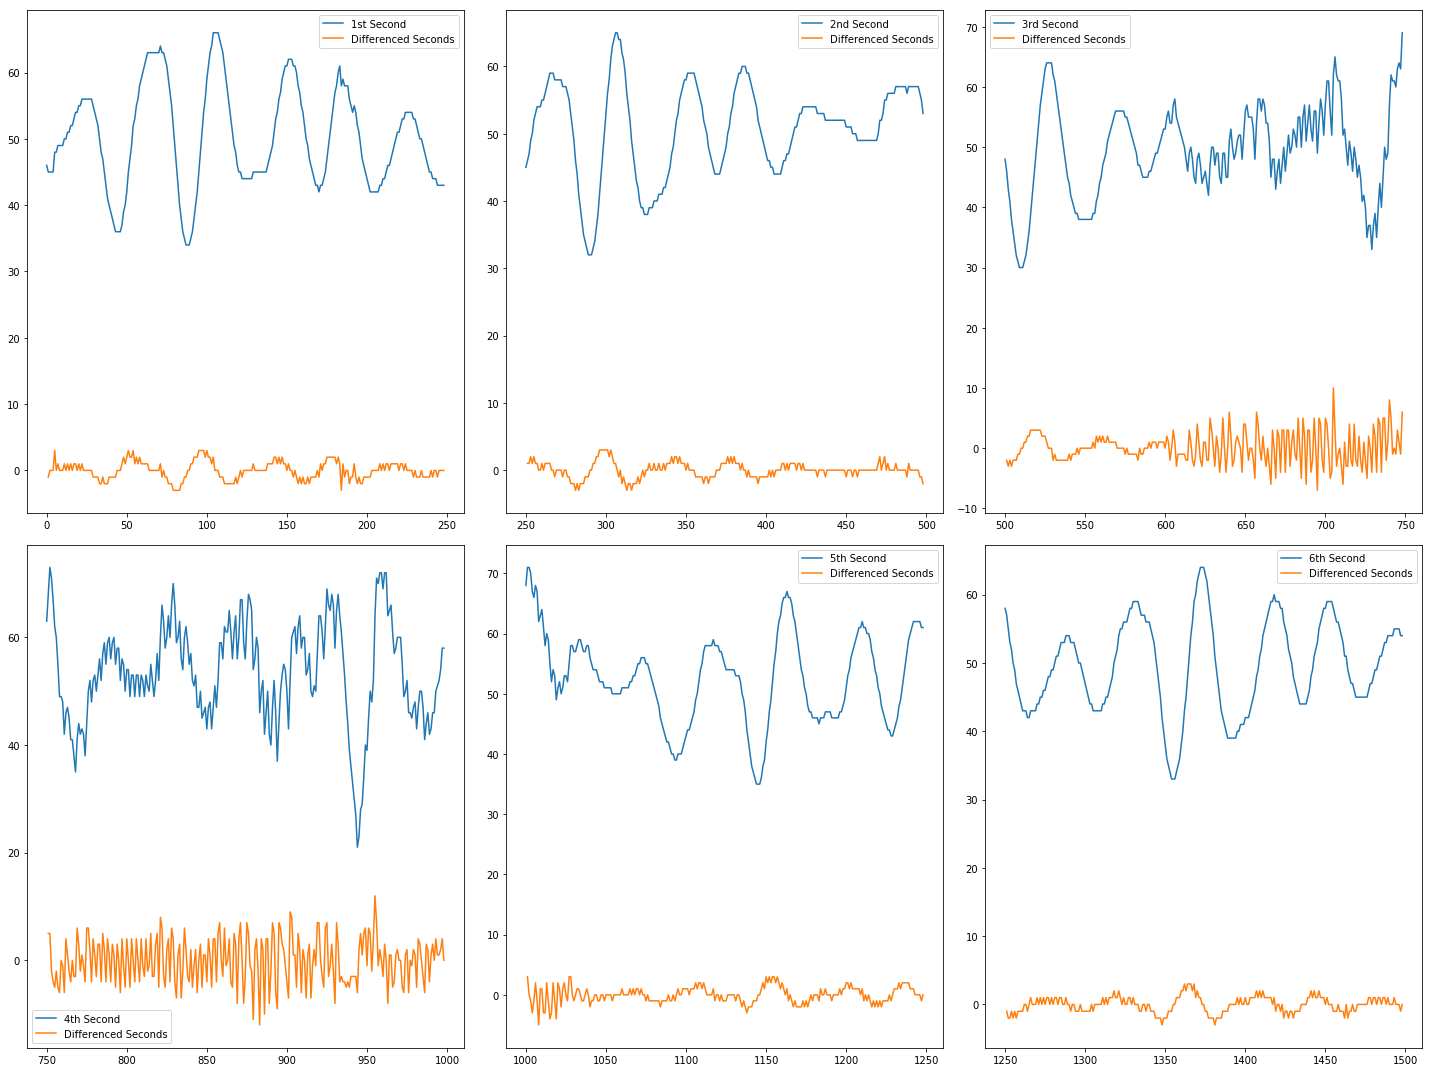

In [5]:
fig, axes = plt.subplots(2,3, sharey=False, sharex=False)
fig.set_figwidth(20)
fig.set_figheight(15)
axes[0][0].plot(test1.index[0:249], test1.Amplitude[0:249], label='1st Second')
axes[0][0].plot(test1.index[0:249], test1.Amplitude[0:249].diff(), label='Differenced Seconds')
axes[0][0].legend(loc='best')
axes[0][1].plot(test1.index[250:499], test1.Amplitude[250:499], label='2nd Second')
axes[0][1].plot(test1.index[250:499], test1.Amplitude[250:499].diff(), label='Differenced Seconds')
axes[0][1].legend(loc='best')
axes[0][2].plot(test1.index[500:749], test1.Amplitude[500:749], label='3rd Second')
axes[0][2].plot(test1.index[500:749], test1.Amplitude[500:749].diff(), label='Differenced Seconds')
axes[0][2].legend(loc='best')
axes[1][0].plot(test1.index[750:999], test1.Amplitude[750:999], label='4th Second')
axes[1][0].plot(test1.index[750:999], test1.Amplitude[750:999].diff(), label='Differenced Seconds')
axes[1][0].legend(loc='best')
axes[1][1].plot(test1.index[1000:1249], test1.Amplitude[1000:1249], label='5th Second')
axes[1][1].plot(test1.index[1000:1249], test1.Amplitude[1000:1249].diff(), label='Differenced Seconds')
axes[1][1].legend(loc='best')
axes[1][2].plot(test1.index[1250:1499], test1.Amplitude[1250:1499], label='6th Second')
axes[1][2].plot(test1.index[1250:1499], test1.Amplitude[1250:1499].diff(), label='Differenced Seconds')
axes[1][2].legend(loc='best')
plt.tight_layout()
plt.show()

**Observations:**

- The Differenced Series in the Snoring region shows a high fluctuation in Wave Amplitude.
- The Differenced Series in non-snoring region is almost constant.

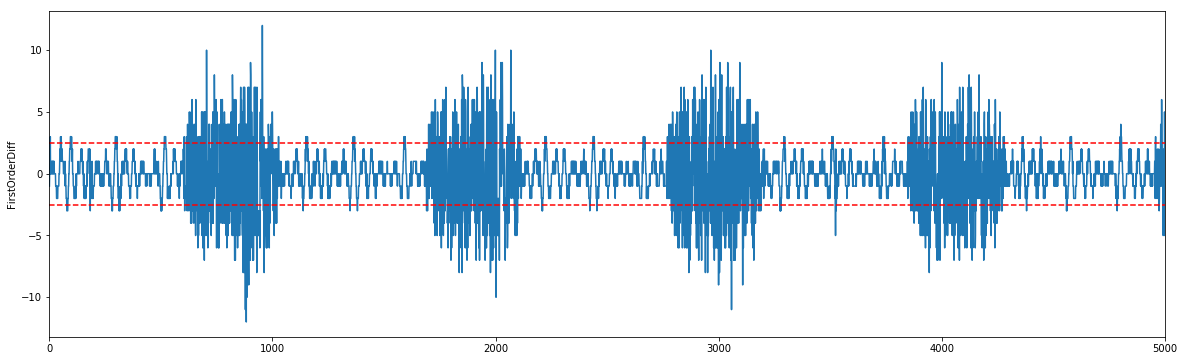

In [13]:
## Viewing the Differenced Series on a 60 second window
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xlim(0,5000)
ax.set_ylabel('1-Differenced Vibration')
test1['FirstOrderDiff'] = test1.Amplitude.diff()
sns.lineplot(x=test1.index, y=test1.FirstOrderDiff, data=test1)
ax.axhline(2.5, ls='--', color='r')
ax.axhline(-2.5, ls='--', color='r')

**Observation:**
- Periodic instances of Snoring are evident.
- Differenced Data is in Wavelet format

# Statistical Analysis

## 5-Point Summary

In [192]:
test1.describe()

,Amplitude,FirstOrderDiff
count,59993.000000,59992.000000
mean,51.344357,0.000150
std,7.377195,1.895782
min,20.000000,-12.000000
25%,47.000000,-1.000000
50%,52.000000,0.000000
75%,56.000000,1.000000
max,73.000000,12.000000


- Observations -> 59993
- Sample Mean -> 51.34 Vibrations/ Second.
- Sample Minimum -> 20 Vibrations/Second.
- Sample Maximum -> 73 Vibrations/Second.

## Feature Engineering

In [97]:
def create_features(df):
    """Function to create the following features:
    1. Avg_Amplitude :  Returns Average Amplitude per 250 Time Stamps.
    2. Min_Amplitude : Returns Minimum Amplitude per 250 Time Stamps.
    3. Max_Amplitude : Returns Maximum Amplitude per 250 Time Stamps.
    4. StDev_Amplitude: Returns Standard Deviation of Amplitude per 250 Time Stamps.
    5. Seconds: Returns value in Seconds ie., between 1-60.
    6. Minute: Returns the n-th minute for a particular record.
    Parameters:
    ----------
    df: pd.DataFrame, Dataset containing Body Vibrations.
    
    Returns:
    --------
    df2: pd.DataFrame, Dataset containing Added Features.
    
    Assumptions:
    ------------
    # Assumption-1 : 250 Time-stamps == 1 Second
    # Assumption-2 : Considering only 3 minutes and 59 seconds. Therefore, 59750 Time-stamps.
    """
    
    df2 = pd.DataFrame(data=None)
    array = df.Amplitude[0:59750].values.reshape(-1,250) 
    df2['Avg_Amplitude'] = [np.mean(i) for i in array]
    df2['Min_Amplitude'] = [np.min(i) for i in array]
    df2['Max_Amplitude'] = [np.max(i) for i in array]
    df2['StDev_Amplitude'] = [np.std(i) for i in array]
    df2['Seconds'] = np.tile([int(i) for i in range(1,61)], array.shape[0])[0:array.shape[0]]
    df2['Minute'] = np.repeat([minute for minute in ['1st', '2nd', '3rd','4th']], 60)[0:array.shape[0]]
    return df2

In [98]:
data_for_analysis_1 = create_features(df=test1)

## Descriptive Analysis on Average Amplitude

 ### Plotting Average Amplitude

Text(0, 0.5, 'Average Amplitude')

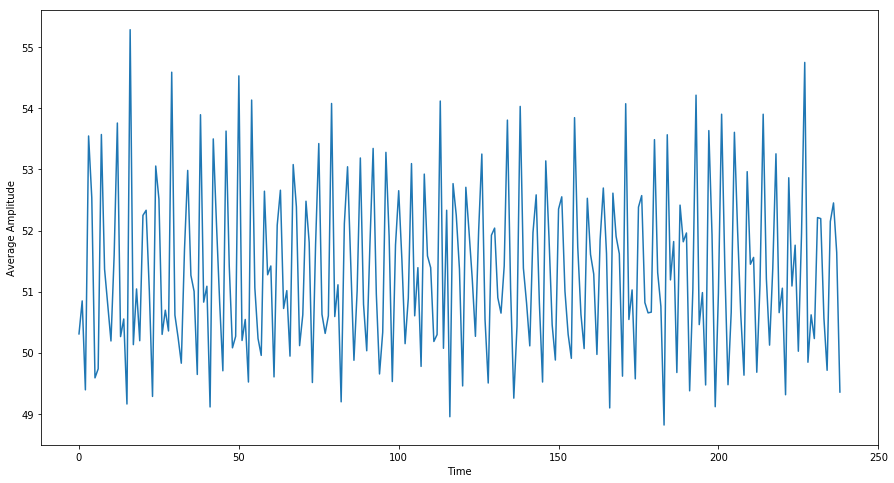

In [114]:
plt.figure(figsize=(15, 8))
plt.plot(data_for_analysis_1['Avg_Amplitude'])
plt.xlabel('Time')
plt.ylabel('Average Amplitude')

**Observation**

- Average Amplitude per second looks stationary without any trend.
- Seasonal Peaks are evident

### Plotting Average Amplitude per second for each minute

In [100]:
seconds_based_amplitude = pd.pivot_table(data_for_analysis_1, values='Avg_Amplitude',\
                                         columns='Minute', index='Seconds')

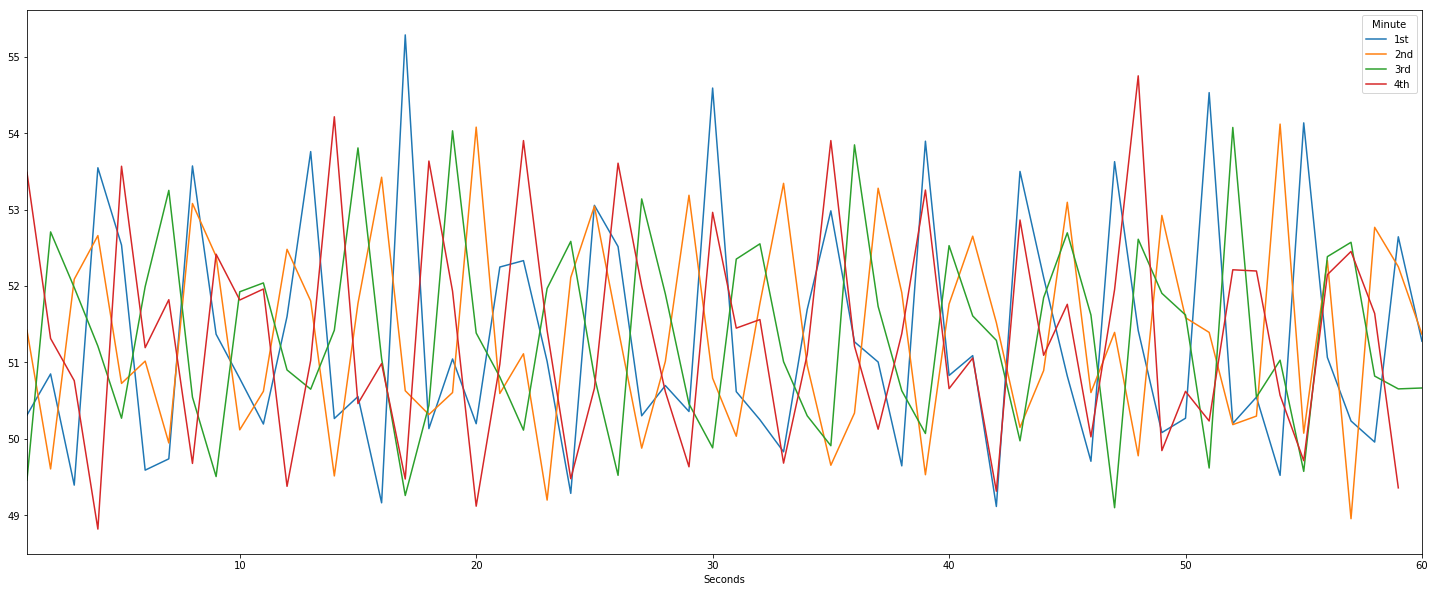

In [323]:
seconds_based_amplitude.plot(figsize=(25,10))

**Observation**
- For a few Seconds, Spikes on 1st minute are more visible.

### Plotting Average Amplitude per minute for each 15 second interval

In [133]:
min_winse_variable = pd.pivot_table(data_for_analysis_1, values='Avg_Amplitude',\
                                         columns='Seconds', index='Minute')

#### First 15 Seconds

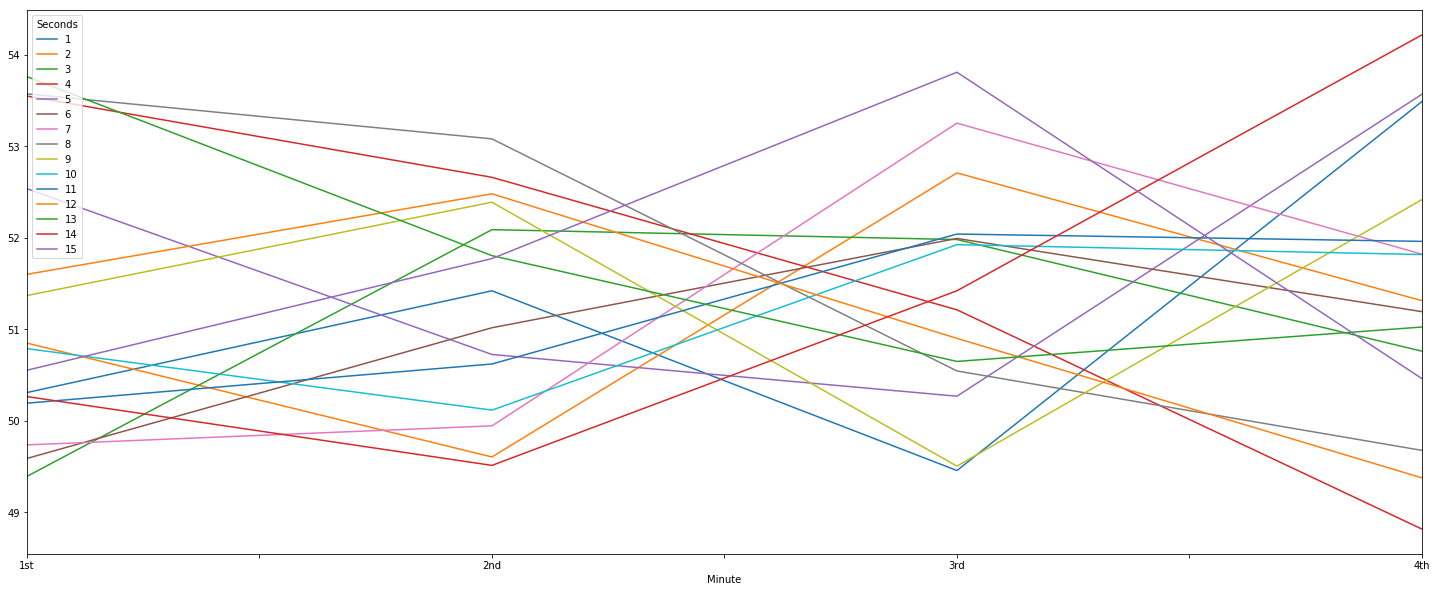

In [324]:
min_winse_variable.loc[:, 1:15].plot(figsize=(25,10))

#### Next 15 Seconds

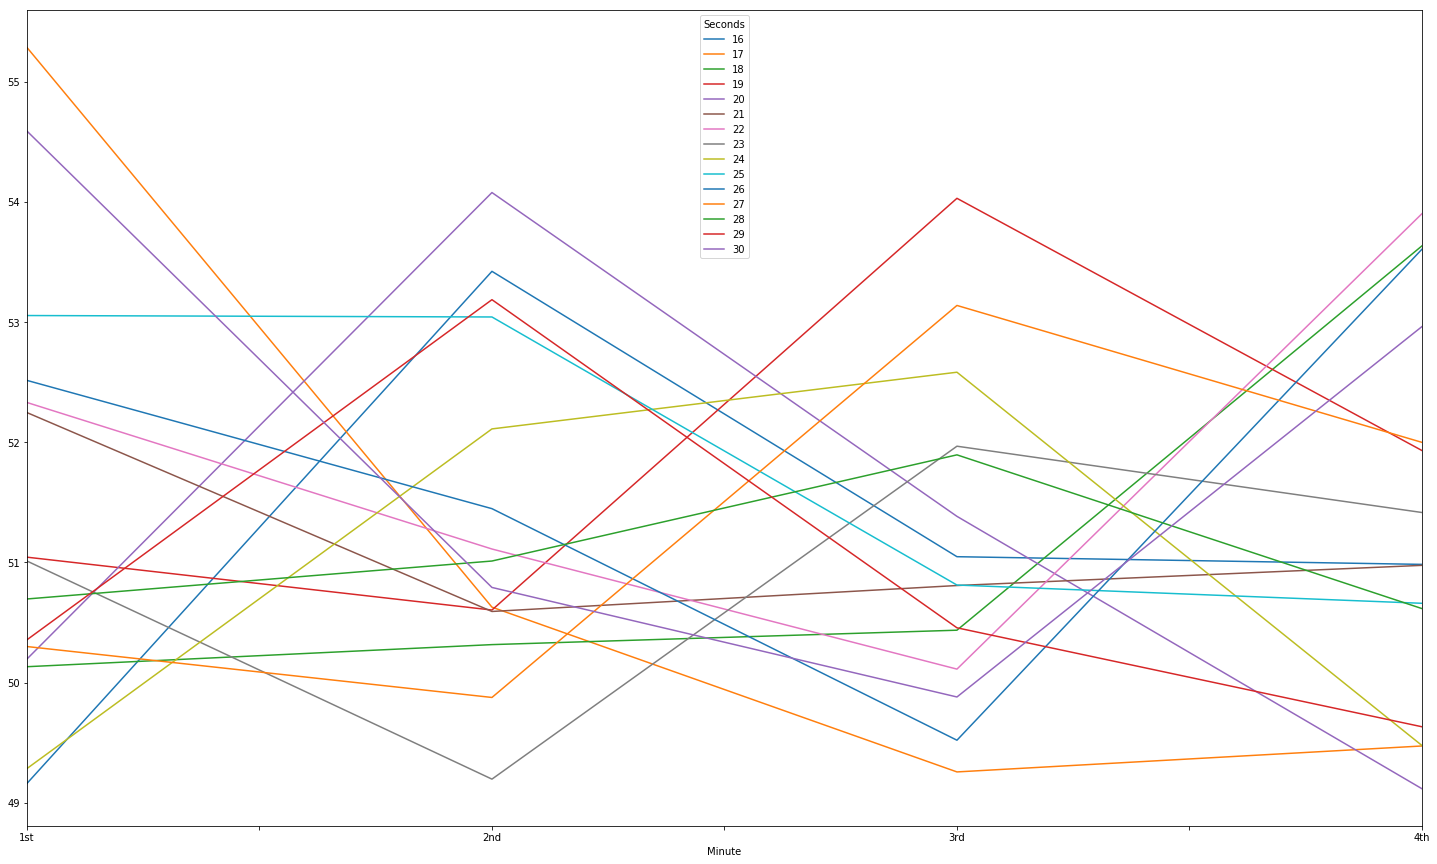

In [139]:
min_winse_variable.loc[:, 16:30].plot(figsize=(25,15))

#### 31st to 45th Second

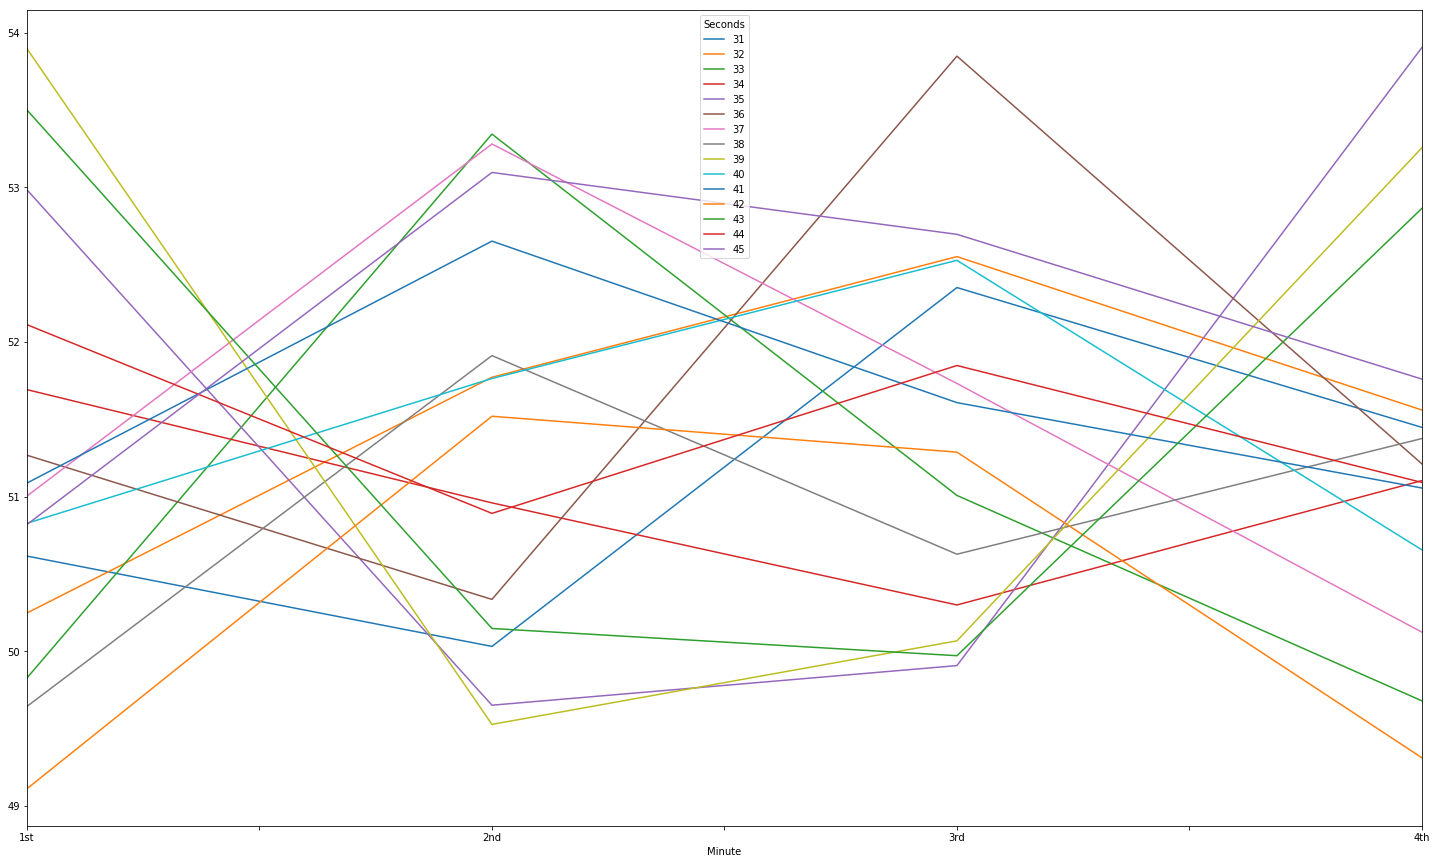

In [140]:
min_winse_variable.loc[:, 31:45].plot(figsize=(25,15))

#### Last 15 Seconds

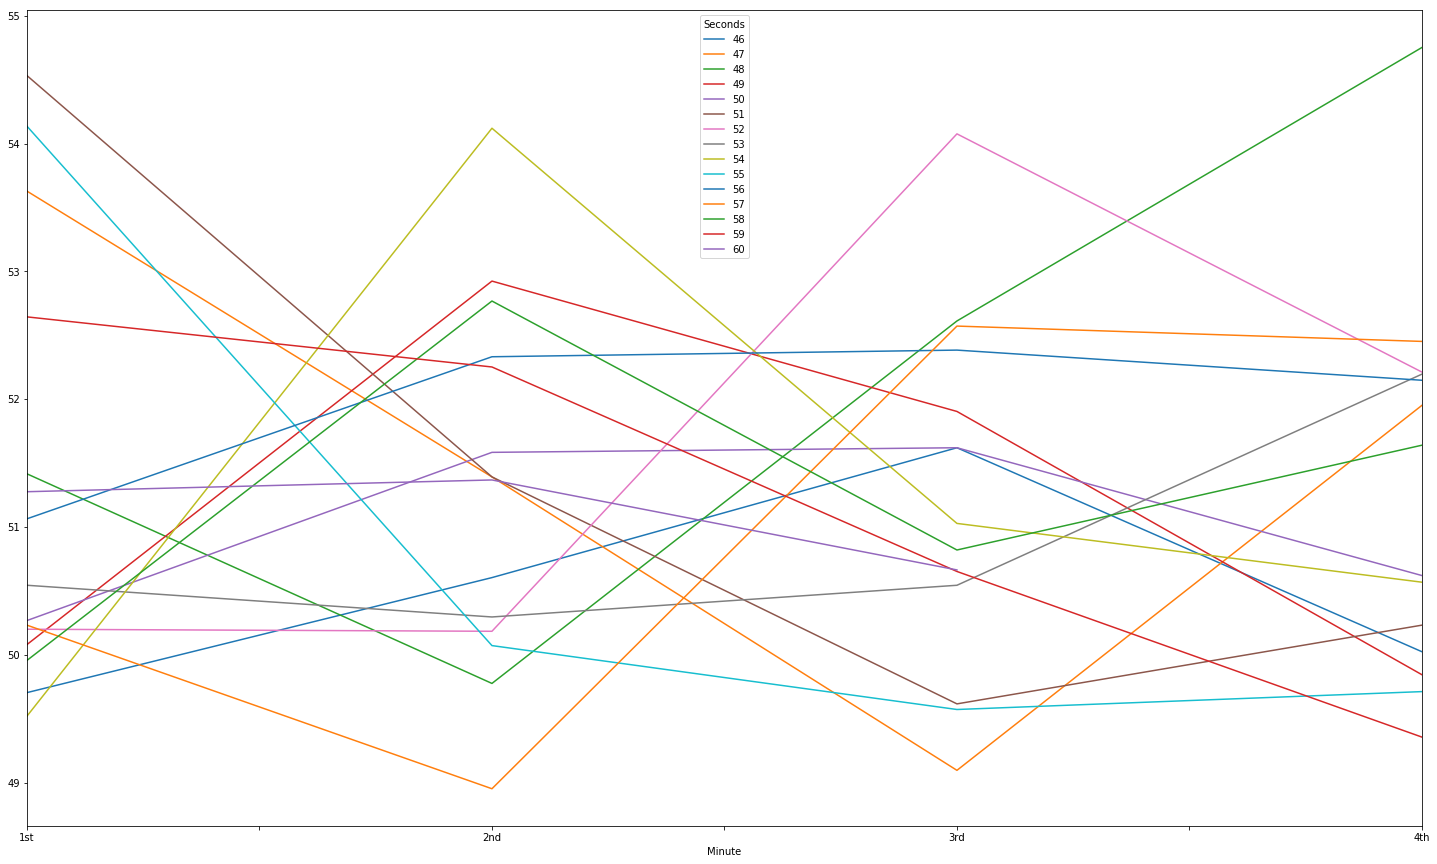

In [141]:
min_winse_variable.loc[:, 46:60].plot(figsize=(25,15))

#### Overall Pattern

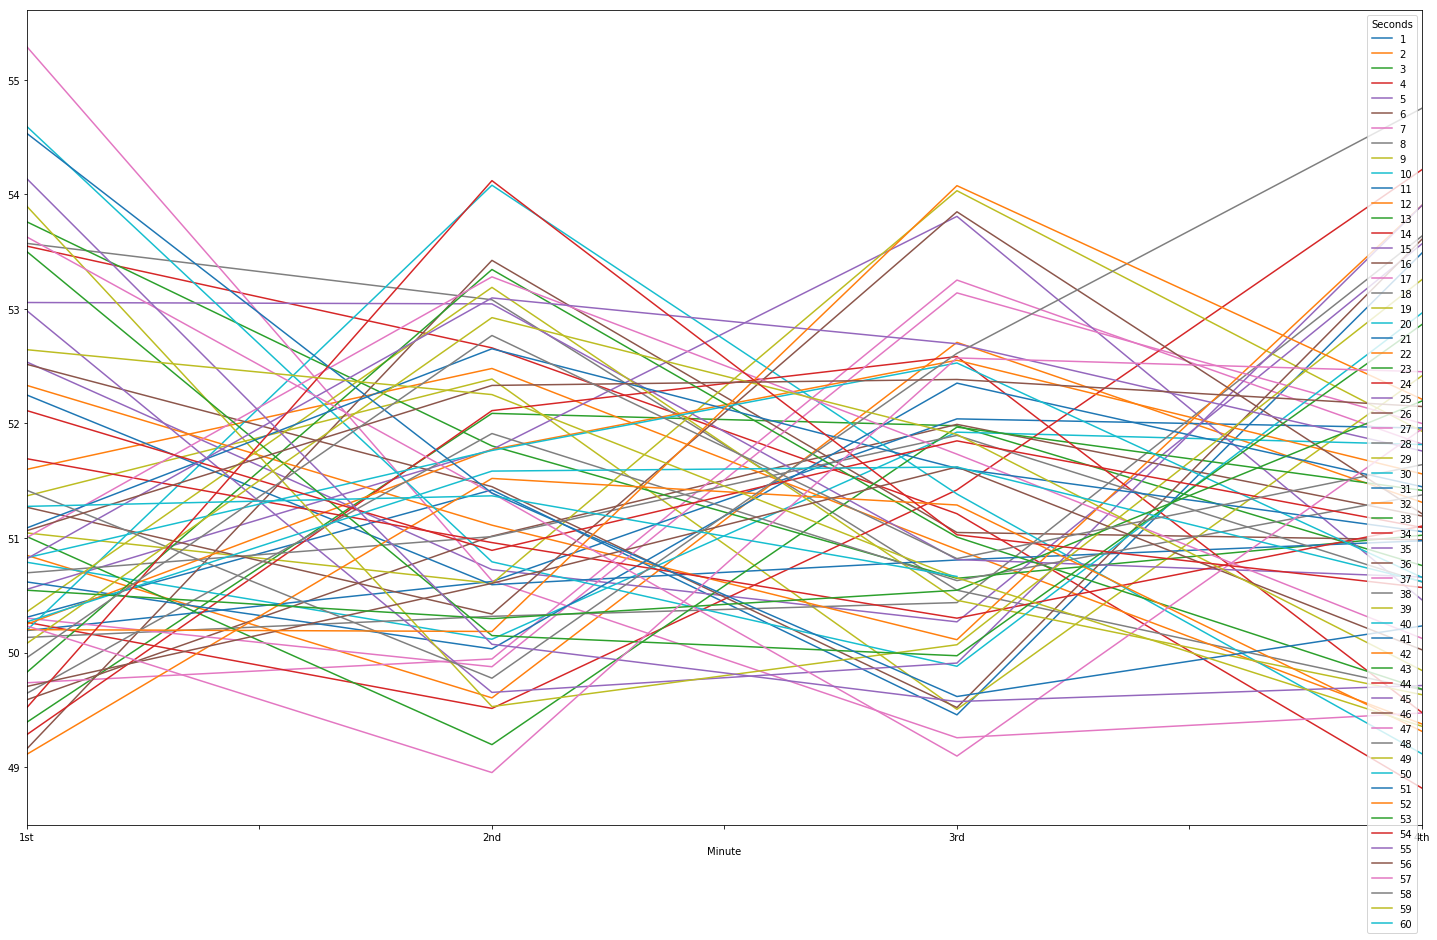

In [142]:
min_winse_variable.plot(figsize=(25,15))

**Observations:**

- Average Amplitude varies a lot for 1st and 4th minute.
- Average Amplitude appears to be between ~49 to ~54 Vibrations.

## Hypothesis Testing

- Based on the above Visual Analysis, several Hypothesis can be generated:
    - Mean Average Amplitude per minute does not change.
    - The Variance of Average Amplitude per minute is Homogeneous.

### Hypothesis : Mean Average Amplitude per minute does not change.

Null Hypothesis: $\mu$ Amplitude(Minute_1) =  $\mu$ Amplitude(Minute_2) =  $\mu\$ Amplitude(Minute_3) = ....

Alternate Hypothesis: At Least One of the minutes have a different Mean Amplitude.

**Assumption:** This sample is a representation of Population Data.

In [148]:
data_for_analysis_1['Seconds'] = data_for_analysis_1.Seconds.astype(str)

In [168]:
# Performing Shapiro's Test to confirm Assumptions of Normality.

def shapiro_test(df):
    """Function to Conduct Shapiro Test.
    Ho : Data is Normally Distributed.
    Ha : Data is not normally distributed."""
    for val in np.unique(df['Minute']):
        p_val = shapiro(df.query('Minute == "{0}"'.format(val))['Avg_Amplitude'])[1]
        if p_val > 0.05:
            print('Data is Normally distributed for {0} Minute'.format(val))
        else:
            print('Data is Not Normally distributed for {0} Minute'.format(val))


In [169]:
shapiro_test(data_for_analysis_1)

Data is Not Normally distributed for 1st Minute
Data is Normally distributed for 2nd Minute
Data is Normally distributed for 3rd Minute
Data is Normally distributed for 4th Minute


### Hypothesis: Average Amplitude per Minute has equal Variance

In [179]:
# Performing Levene's Test to confirm Equal Variance.

# Ho: All variances are equal
# Ha: Atleast one of the variances not equal

levene_pval = levene(data_for_analysis_1.query('Minute == "1st"')['Avg_Amplitude'],\
       data_for_analysis_1.query('Minute == "2nd"')['Avg_Amplitude'],\
       data_for_analysis_1.query('Minute == "3rd"')['Avg_Amplitude'],\
       data_for_analysis_1.query('Minute == "4th"')['Avg_Amplitude'] )[1]

if levene_pval > 0.05:
    print('We fail to reject the Null-Hypothesis that Variance is Equal')
    
else:
    print('Insufficient Evidence to conclude that Variance is Equal')

We fail to reject the Null-Hypothesis that Variance is Equal


- <h5> Since thecondition of Homogeneous Variance is met,ANOVA can be conducted.</h5>

In [184]:
## One-Way ANOVA

anova_model = ols('Avg_Amplitude ~ C(Minute)', data=data_for_analysis_1).fit()

aov_table = anova_lm(anova_model, type=1)

print(aov_table)

              df      sum_sq   mean_sq         F    PR(>F)
C(Minute)    3.0    0.142173  0.047391  0.024365  0.994843
Residual   235.0  457.080175  1.945022       NaN       NaN


<h5> I performed a One-Way ANOVA to compare the Average Amplitude of 4 time groups.     
    This analysis produced no statistically significant result. </h5>

# Snore Detection



##  Spindle Analysis

### Defining Parameters

In [264]:
# Defining the sampling frequency and Time Vector
sf = 250
times = np.arange(test1.Amplitude.size)/sf

### Wavelet Convolution

- Used Morlet's Wavelet for convolving.

**Reasons:**
- Able to create small signals like spindles.
- When multiplied with real spindle in the dataset, results in high Amplitude signal wrt the Spindle.

Based on the analysis of :[Dr. Raphael Vallet](https://github.com/raphaelvallat/yasa/tree/v0.1.4)

Text(0, 0.5, 'Amplitude')

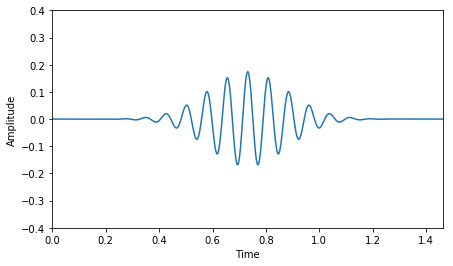

In [265]:
# Parameters
cf = 13     # Central spindles frequency in Hz
nc = 12     # Number of oscillations in the spindles

# Compute the wavelet
wlt = morlet(sf, [cf], n_cycles=nc)[0]

 # Plot
t = np.arange(wlt.size) / sf
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(t, wlt)
plt.ylim(-0.4, 0.4)
plt.xlim(t[0], t[-1])
plt.xlabel('Time')
plt.ylabel('Amplitude')

**NOTE:**
- Spindle Frequency is dependent on Age, so tuning is always required based on Patient/Sample.



In [289]:
# Convolve the wavelet and extract magnitude and phase
def Wavelet_Formation(df, threshold, window_1, window_2):
    """
    Function to generate comparative graphs for spindle detection and analysis.
    
    Parameters:
    -----------
    df: pd.Dataframe, Contains Ballistography Data.
    threshold:  float, Act as cut-off factor on Normalized Wavelet.
    window_1: int, starting Time stamp in the Graph
    window_1: int, Ending Time stamp in the Graph
    
    Returns:
    --------
    
    Graph-1: 1). Amplitude V/S Time-Stamps 2). Differenced Series Amplitude V/S Time-Stamps.
    Graph-2: Normalized Wavelet Power(cutoff set by threshold) V/S Time-Stamps.
    """
    df['FirstOrderDiff'] = df['Amplitude'].diff().bfill()
    analytic = np.convolve(df.FirstOrderDiff, wlt, mode='same')
    magnitude = np.abs(analytic)
    phase = np.angle(analytic)
    # Square and normalize the magnitude from 0 to 1 (using the min and max)
        # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(magnitude)
    norm_power = (power - power.min()) / (power.max() - power.min())
        # Define the threshold
    thresh = threshold
        # Find supra-threshold values
    supra_thresh = np.where(norm_power >= thresh)[0]
        # Create vector for plotting purposes
    val_spindles = np.nan * np.zeros(df.FirstOrderDiff.size)
    val_spindles[supra_thresh] = df.Amplitude[supra_thresh]
            # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)
    ax1.plot(df.index, df.Amplitude, lw=1.5, label = 'Actual Value')
    ax1.plot(df.index, df.FirstOrderDiff, lw=1.5, label= 'Differenced Series')
    ax1.plot(df.index, val_spindles, color='red', alpha=.8, label='Detected Anomaly') ## Red Region marks the detected Snoring Region.
    ax1.set_xlim(window_1, window_2)
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Comparison Graph')
    ax1.legend(loc='best')
    
    ax2.plot(df.index,norm_power)
    ax2.set_xlabel('Time-stamps')
    ax2.set_ylabel('Normalized wavelet power')
    ax2.axhline(thresh, ls='--', color='indianred', label='Threshold')
    ax2.fill_between(df.index, norm_power, thresh, where = norm_power >= thresh,color='indianred', alpha=.8)
    plt.legend(loc='best')

<h5> Viewing for first 4000 Time Stamps</h5>

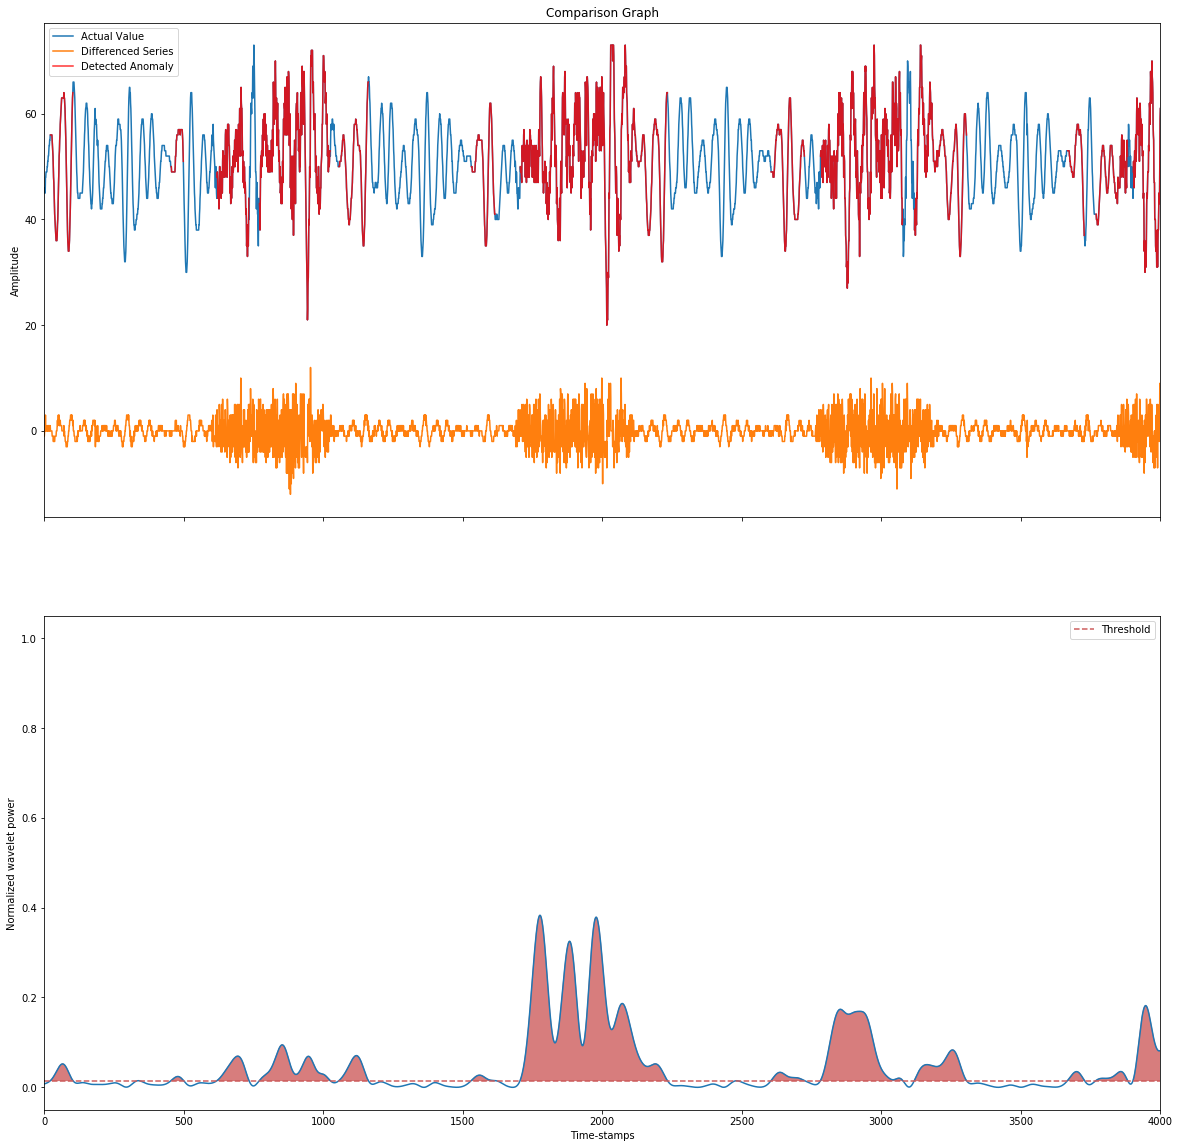

In [316]:
Wavelet_Formation(df=test1,threshold=0.015, window_1=0, window_2=4000)

<h5> Viewing for next 6000 Time Stamps</h5>

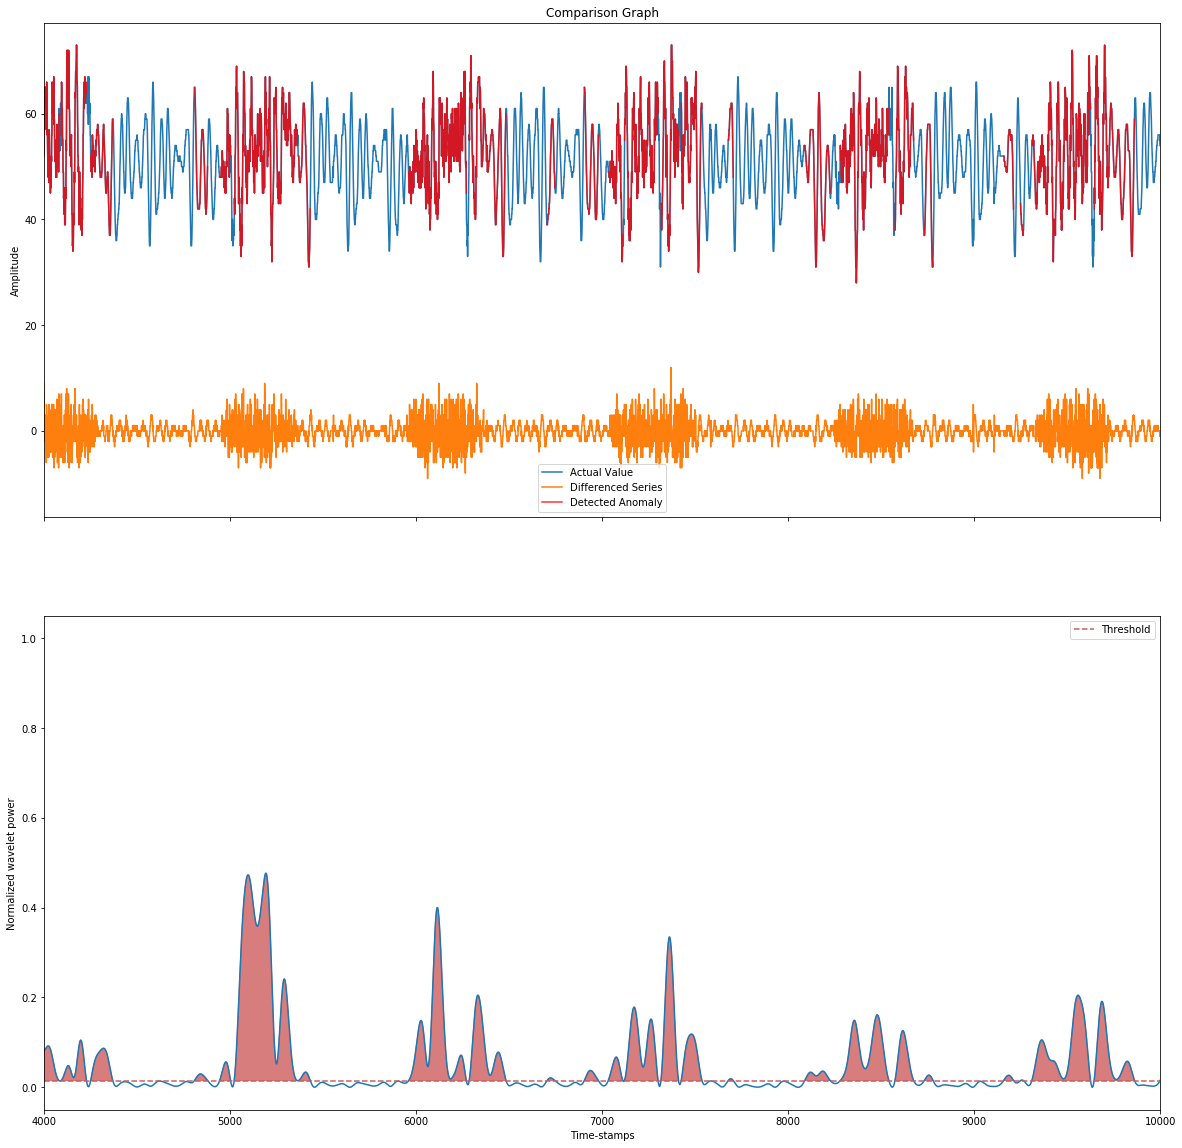

In [319]:
Wavelet_Formation(df= test1,threshold=0.015, window_1=4000, window_2=10000)

**The current threshold is able to capture majority of spindles for the given Sample**

## Based on Mean Squared Error of Differenced Term

In [310]:
def anomaly_detection(df, threshold, min_x, max_x):
    """
    Function to Visually inspect Sleep spindles based on threshold.
    Parameters:
    -----------
    df: pd.Dataframe, Data file required for Analysis.
    threshold: float, Cut-off factor for demarcating Anomaly.
    min_x: int, starting value in x-axis.
    max_x: int, stopping value in x-axis.
    """
    df['NthOrderDiff'] = df['Amplitude'].diff().diff().bfill()
    df['MSE'] = (df['NthOrderDiff'] - np.mean(df.NthOrderDiff))**2
    threshold = threshold
    constraint = np.where(test2.MSE>threshold)[0]
    
    # Creating an Empty Vector
    vector = np.nan * np.zeros(test2.MSE.size)
    vector[constraint] = df.Amplitude[constraint]
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax1.plot(df.index, df.Amplitude, lw=1.5, label='Actual')
    
    ax1.plot(df.index, vector, color='red', alpha=.8, label='Detected Anomaly')
    ax1.set_xlim(min_x,max_x)
    ax1.set_ylim(0,100)
    ax1.legend(loc='best')
    
    ax2.plot(df.index, df.MSE, lw=1.5, label= 'Differenced Series')
    
    plt.legend(loc='best')



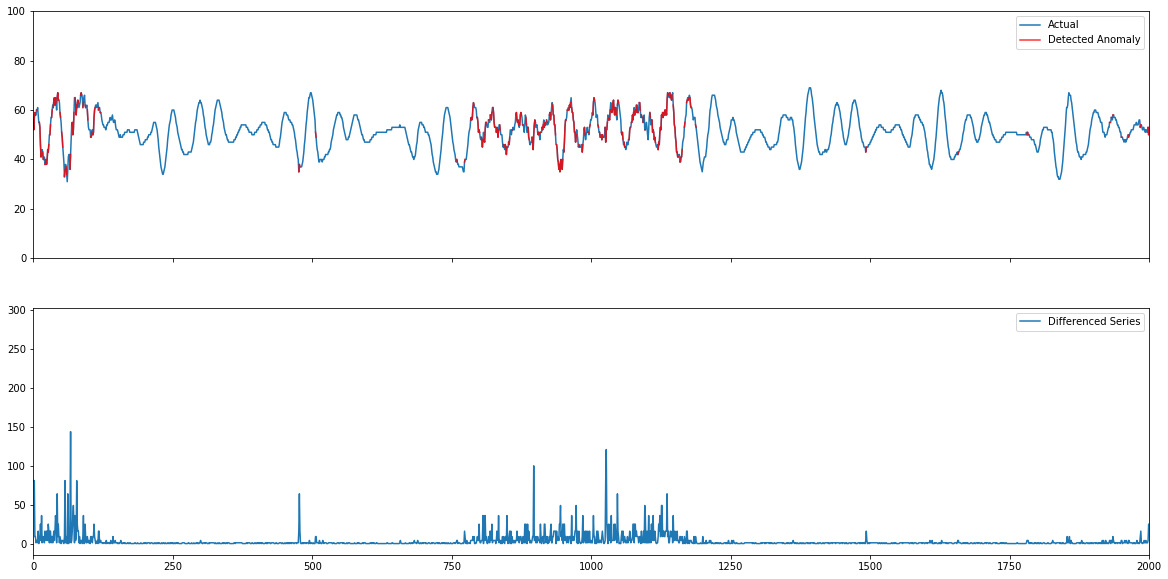

In [315]:
anomaly_detection(df=test2, threshold=2, min_x=0,max_x=2000)

# Appendix

## Windowing

- Required for Signal Modulation: Magnitude of Signal reduced to zero at beginning and end of the sampling duration.

In [200]:
amps = test1.Amplitude.values

In [201]:
window = signal.blackman(len(amps))

amps_windowed = amps*window

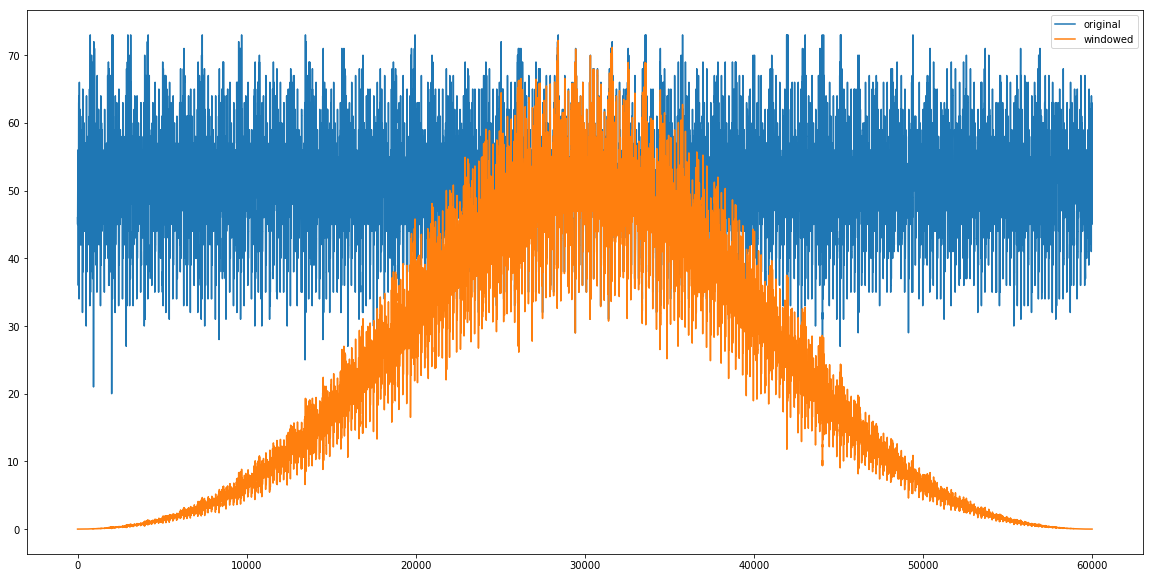

In [202]:
fig, ax = plt.subplots(figsize=(20,10))
# ax.set_xlim(0,10000)
ax.plot(test1.index, amps, label='original')
ax.plot(test1.index, amps_windowed, label = 'windowed')
ax.legend(loc='best')

## Spectral Analysis

In [203]:
F = fftpack.fft(amps)

In [204]:
N = len(amps_windowed)
f = fftpack.fftfreq(n=len(amps_windowed))

Text(0, 0.5, '$|F|/N$')

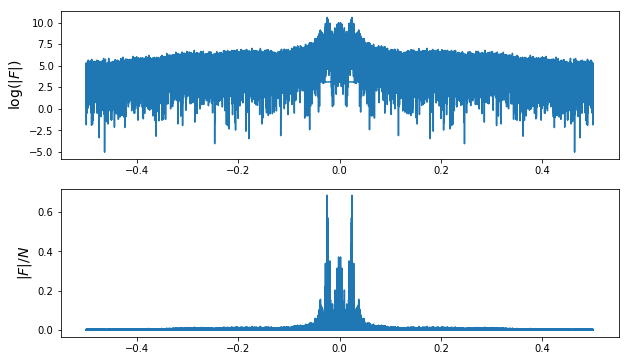

In [205]:
fig, axis = plt.subplots(2,1, figsize=(10,6))
axis[0].plot(f, np.log(abs(F.imag)), label='Real')
axis[0].set_ylabel("$\log(|F|)$", fontsize=14)
axis[1].plot(f, abs(F.imag)/N, label="Real")
axis[1].set_ylabel("$|F|/N$", fontsize=14)


## Frqequency Domain Filter

In [206]:
F_Filtered = F*(abs(f)>0.4)

In [207]:
f_t_filtered = fftpack.ifft(F_Filtered)

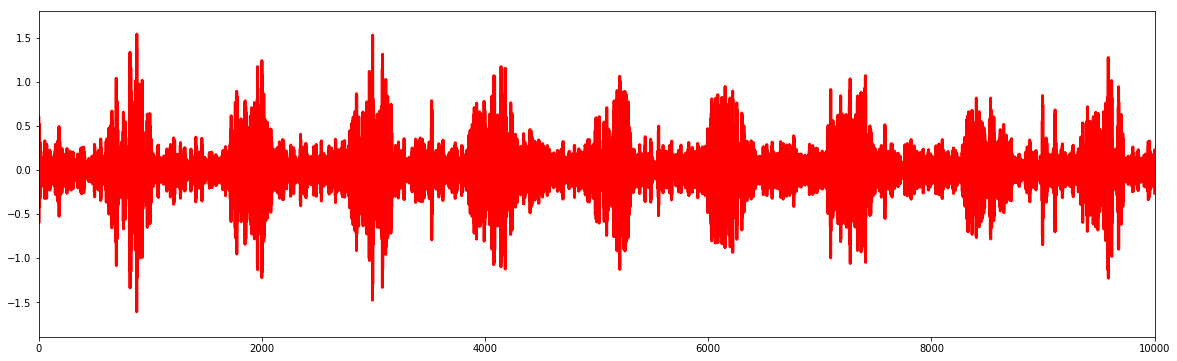

In [208]:
fig, ax = plt.subplots(figsize=(20,6))
#ax.plot(test1.index, amps, label='original')
ax.set_xlim(0,10000)
ax.plot(test1.index,f_t_filtered.real, color="red", lw=3, label='filtered')